<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example we will use RNN models (vanilla and LSTM) in TF2 to forecast the Tesla (TSLA) stock price.  It is based on the time series example at https://www.tensorflow.org/tutorials/structured_data/time_series. 

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(1)

In [64]:
print(tf.__version__)

2.1.0


Read in CSV file using Pandas

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/adammoss/MLiS2/master/examples/rnn/TSLA.csv')

In [66]:
len(df)

2429

In [67]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Define function to extract many-to-one training data examples

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [69]:
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()

Date
2010-06-29    23.889999
2010-06-30    23.830000
2010-07-01    21.959999
2010-07-02    19.200001
2010-07-06    16.110001
Name: Close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56a594e898>],
      dtype=object)

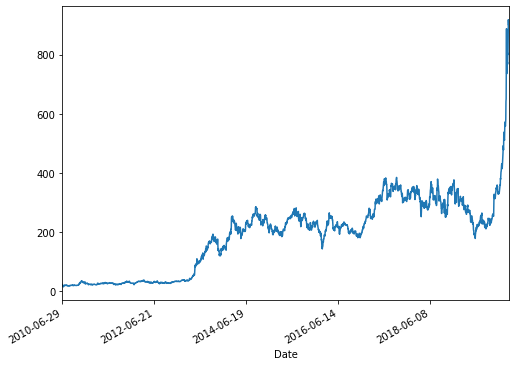

In [70]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

Using first 2000 examples as training data

In [0]:
TRAIN_SPLIT = 2000

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardise the data

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Use the last 20 observations to learn to predict the value at the next time step.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [76]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(1980, 20, 1)
(1980,)
(409, 20, 1)
(409,)


In [77]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target value to predict')
print (y_train_uni[0])

Single window of past history
[[-1.23801939]
 [-1.23855722]
 [-1.25532006]
 [-1.28006089]
 [-1.30775989]
 [-1.31053877]
 [-1.29565841]
 [-1.29619624]
 [-1.29933368]
 [-1.28956283]
 [-1.27432389]
 [-1.2738757 ]
 [-1.26715264]
 [-1.25576825]
 [-1.27020043]
 [-1.27091755]
 [-1.26392556]
 [-1.26132597]
 [-1.26437376]
 [-1.26795941]]

 Target value to predict
-1.2664355126748814


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

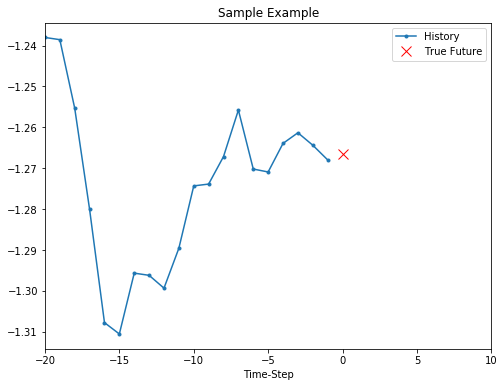

In [82]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

In [0]:
def build_model(RNN, hidden_units):
  model = tf.keras.models.Sequential([
    RNN(hidden_units, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

First try a vanilla RNN model


In [0]:
rnn_model = build_model(tf.keras.layers.SimpleRNN, 16)

In [119]:
rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 16)                288       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [120]:
history = rnn_model.fit(x_train_uni, y_train_uni, epochs=EPOCHS, validation_data=(x_val_uni, y_val_uni))

Train on 1980 samples, validate on 409 samples
Epoch 1/10
1980/1980 [==============================] - 1s 543us/sample - loss: 0.0459 - mae: 0.1401 - mse: 0.0459 - val_loss: 0.7949 - val_mae: 0.3275 - val_mse: 0.7949
Epoch 2/10
1980/1980 [==============================] - 0s 156us/sample - loss: 0.0065 - mae: 0.0548 - mse: 0.0065 - val_loss: 0.7481 - val_mae: 0.3105 - val_mse: 0.7481
Epoch 3/10
1980/1980 [==============================] - 0s 164us/sample - loss: 0.0051 - mae: 0.0473 - mse: 0.0051 - val_loss: 0.7017 - val_mae: 0.2953 - val_mse: 0.7017
Epoch 4/10
1980/1980 [==============================] - 0s 169us/sample - loss: 0.0043 - mae: 0.0438 - mse: 0.0043 - val_loss: 0.6666 - val_mae: 0.2836 - val_mse: 0.6666
Epoch 5/10
1980/1980 [==============================] - 0s 161us/sample - loss: 0.0038 - mae: 0.0404 - mse: 0.0038 - val_loss: 0.6409 - val_mae: 0.2758 - val_mse: 0.6409
Epoch 6/10
1980/1980 [==============================] - 0s 164us/sample - loss: 0.0035 - mae: 0.0381 - 

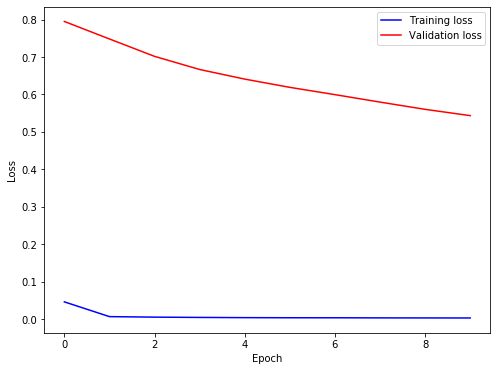

In [121]:
plt.figure()
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'b', label='Training loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

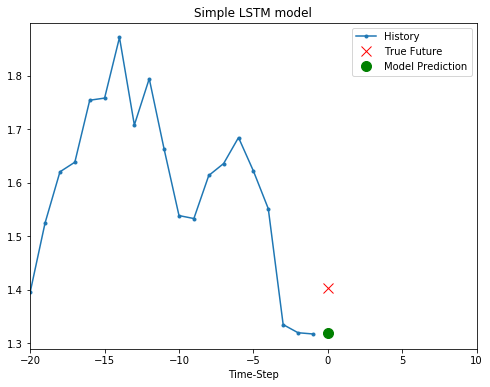

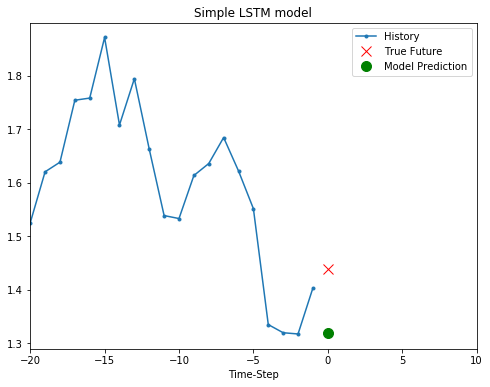

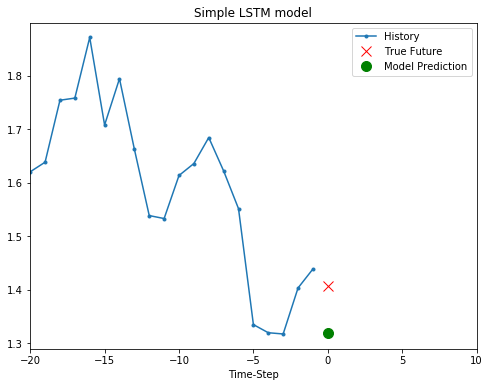

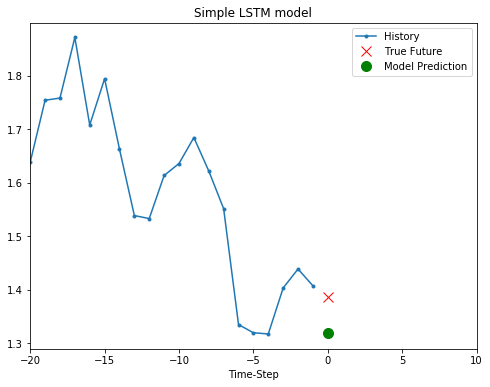

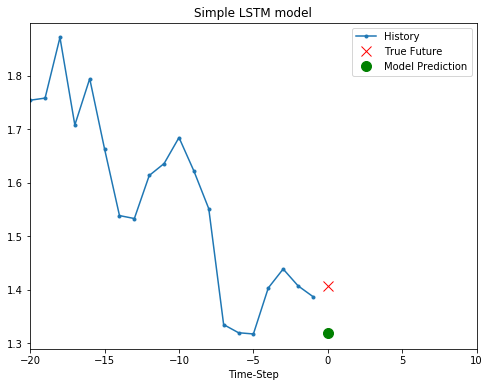

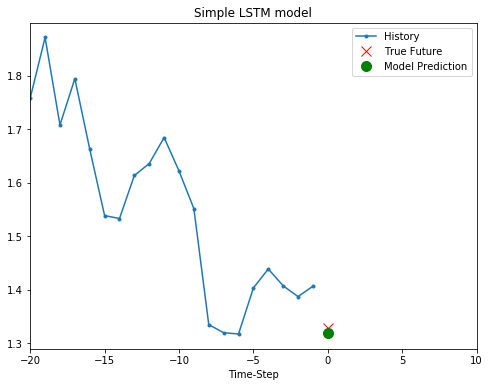

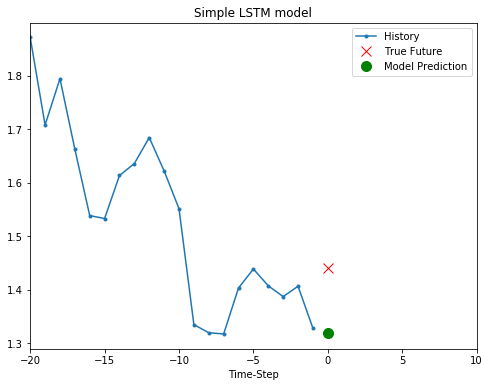

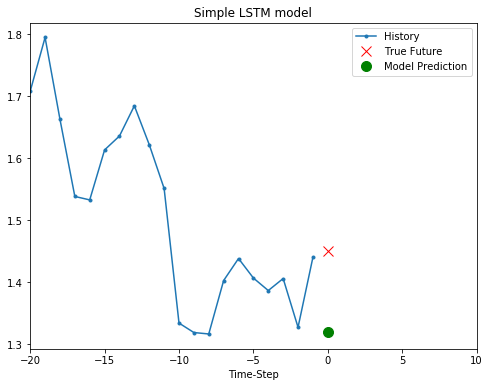

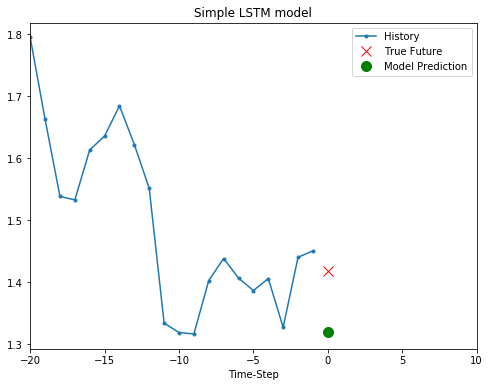

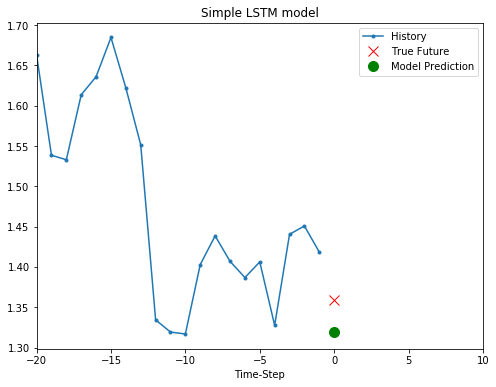

In [123]:
for i in range(10):
  plot = show_plot([x_val_uni[i], y_val_uni[i],
                    rnn_model.predict(x_val_uni[0:1])[0]], 0, 'Simple RNN model')
  plot.show()


In [0]:
lstm_model = build_model(tf.keras.layers.LSTM, 16)

In [125]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [126]:
history = lstm_model.fit(x_train_uni, y_train_uni, epochs=EPOCHS, validation_data=(x_val_uni, y_val_uni))

Train on 1980 samples, validate on 409 samples
Epoch 1/10
1980/1980 [==============================] - 2s 1ms/sample - loss: 0.1813 - mae: 0.3062 - mse: 0.1813 - val_loss: 0.8264 - val_mae: 0.4012 - val_mse: 0.8264
Epoch 2/10
1980/1980 [==============================] - 1s 289us/sample - loss: 0.0180 - mae: 0.0973 - mse: 0.0180 - val_loss: 0.6934 - val_mae: 0.3508 - val_mse: 0.6934
Epoch 3/10
1980/1980 [==============================] - 1s 290us/sample - loss: 0.0121 - mae: 0.0793 - mse: 0.0121 - val_loss: 0.6294 - val_mae: 0.3264 - val_mse: 0.6294
Epoch 4/10
1980/1980 [==============================] - 1s 307us/sample - loss: 0.0092 - mae: 0.0679 - mse: 0.0092 - val_loss: 0.5787 - val_mae: 0.3107 - val_mse: 0.5787
Epoch 5/10
1980/1980 [==============================] - 1s 311us/sample - loss: 0.0076 - mae: 0.0610 - mse: 0.0076 - val_loss: 0.5515 - val_mae: 0.2987 - val_mse: 0.5515
Epoch 6/10
1980/1980 [==============================] - 1s 287us/sample - loss: 0.0068 - mae: 0.0571 - ms

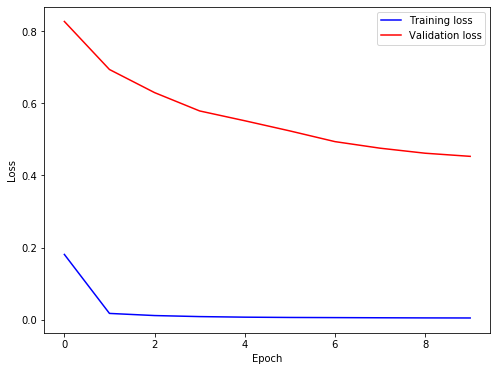

In [127]:
plt.figure()
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'b', label='Training loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

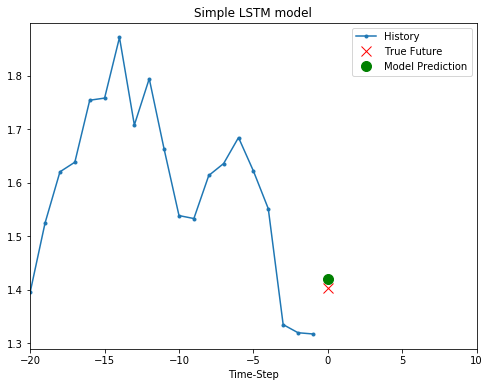

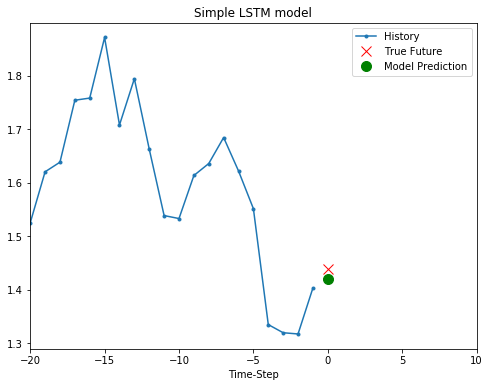

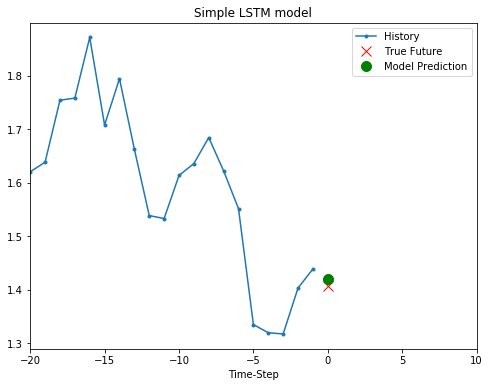

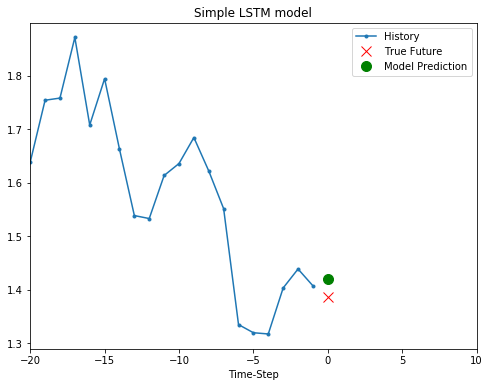

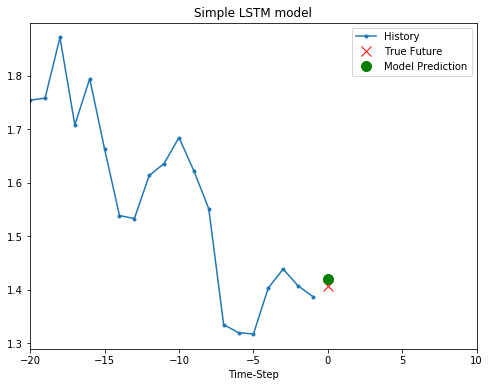

In [129]:
for i in range(5):
  plot = show_plot([x_val_uni[i], y_val_uni[i],
                    lstm_model.predict(x_val_uni[0:1])[0]], 0, 'Simple LSTM model')
  plot.show()
